In [35]:
# ESTIMACIÓN DE PROBABILIDADES DE INCUMPLIMIENTO EN EL TIEMPO

In [36]:
#La obtención de probabilidades de incumplimiento es una parte fundamental en la toma de decisiones en las instituciones de crédito. La probabilidad de incumplimiento se define en general como la probabilidad de que un acreditado no cumpla con las obligaciones de su crédito durante 90 días o más.

In [37]:
## 1. Objetivo:

In [38]:
#Análisis de las Probabilidades de Incumplimiento de créditos hipotecarios de Estados Unidos para identificar periodos de crisis mediante el uso de las herramientas vistas en el curso de Análisis Numérico y Computo Científico.

In [39]:
## 2. Datos:

In [40]:
#Se utilizará la información de 60 trimestres de 5000 créditos hipotecarios de Estados Unidos tomada de protafolios bursatilizado (RMBSs) a partir del año 2000 (hasta 2015). El proveedor de la base es el International Financial Reasearch (www.internationalfinancialreaserch.org), y se tiene acceso a ella por la adquisición del libro Deep Credit Risk de Daniel Rosch y Harald Scheule, que es la principal fuente de este trabajo.

In [41]:
#3. Desarrollo:

In [42]:
### Importación de laS librerías

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.matlib
import pandas as pd
import sklearn
import statsmodels.api as sm
import statsmodels.formula.api as smf
import boto3
import io
from io import StringIO

from numpy import linalg
from scipy.stats import *
from scipy.stats import binom, beta, expon, mvn, randint as sp_randint, shapiro, ttest_ind, bernoulli
from sklearn import metrics
from sklearn.calibration import calibration_curve
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, SGDClassifier
#from statsmodels.tools.eval_measures import rmse, aic
from sklearn.preprocessing import StandardScaler


In [44]:
#Esta función se utiliza para determinar el número de dígitos de precisión que se imprimen

In [45]:
np.set_printoptions(precision=3, suppress=True)

In [46]:
### Conexión a la instancia S3

In [47]:
#Definición de los parámetros para la conexión a S3

In [48]:
s3client = boto3.client(
    's3',
    region_name='us-east-1'
)

In [49]:
#Asignación del nombre del bucket de S3 y de los datos

In [50]:
bucketname = "bucket-mno-2020-v2"
file_to_read = "data_t_final.csv"

In [51]:
#Definición objeto de S3 para conectarnos

In [52]:
fileobj = s3client.get_object(
    Bucket=bucketname,
    Key=file_to_read
    )

In [53]:
### Lectura del archivo, decodificación  y conversión a dataframe

In [54]:
#Lectura del archivo

In [55]:
filedata = fileobj['Body'].read()

In [56]:
#Decodificación del archivo

In [57]:
contenido = filedata.decode('utf-8')

In [58]:
#Tipo de archivo

In [59]:
type(contenido)

str

In [60]:
#Conversión del archivo a dataframe

In [61]:
StringData = StringIO(contenido)

In [62]:
#Lectura del archivo

In [63]:
df = pd.read_csv(StringData)

In [64]:
#Visualización del archivo

In [65]:
df

,id,time,orig_time,first_time,mat_time,res_time,balance_time,LTV_time,interest_rate_time,rate_time,...,FICO_orig_time,LTV_orig_time,Interest_Rate_orig_time,state_orig_time,hpi_orig_time,default_time,payoff_time,status_time,lgd_time,recovery_res
0,4,25,-2,25,119,NaN,61031.10,33.911009,10.500,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
1,4,26,-2,25,119,NaN,60882.42,34.007232,10.500,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
2,4,27,-2,25,119,NaN,60729.80,34.335349,10.500,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
3,4,28,-2,25,119,NaN,60576.14,34.672545,10.875,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
4,4,29,-2,25,119,NaN,60424.39,34.951639,10.875,5.90,...,587,81.8,10.5,KY,97.99,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62173,49972,52,25,52,145,NaN,180673.24,103.306966,7.500,5.15,...,708,79.8,7.5,AL,226.29,0,0,0,NaN,NaN
62174,49972,53,25,52,145,NaN,179944.95,95.736862,7.500,5.15,...,708,79.8,7.5,AL,226.29,0,0,0,NaN,NaN
62175,49972,54,25,52,145,NaN,179451.81,91.867079,7.500,5.15,...,708,79.8,7.5,AL,226.29,0,0,0,NaN,NaN
62176,49972,55,25,52,145,NaN,178952.48,91.560581,7.500,5.15,...,708,79.8,7.5,AL,226.29,0,0,0,NaN,NaN


In [66]:
#Limpieza de la base de datos

In [67]:
# Quitamos renglones con datos nulos

In [68]:
data = df.dropna(subset=['time', 'default_time','LTV_time', 'FICO_orig_time']).copy()

In [69]:
### Data Engineering (falta la selección de las mejores variables

In [70]:
#Impresión del nombre de las columnas

In [71]:
for col in data.columns: 
    print(col) 

id
time
orig_time
first_time
mat_time
res_time
balance_time
LTV_time
interest_rate_time
rate_time
hpi_time
gdp_time
uer_time
REtype_CO_orig_time
REtype_PU_orig_time
REtype_SF_orig_time
investor_orig_time
balance_orig_time
FICO_orig_time
LTV_orig_time
Interest_Rate_orig_time
state_orig_time
hpi_orig_time
default_time
payoff_time
status_time
lgd_time
recovery_res


In [72]:
### Modelo

In [73]:
# La variable dependiente del modelo de regresión logística es "default-time" que da información relacionada con el incumplimiento de pago en cada período de tiempo. Es una variable binomial con valores 0 o 1.

In [74]:
# Se presenta un modelo que incluye todas las variables, una vez realizada la ingeniería de datos se realizará con las variables que más aportación tengan sobre la varianza total de la variable dependiente. Asimismo, fata decidir respecto a si se evaluará el modelo contra un conjunto de prueba.

In [75]:
# La regresión se realiza utilizando una función para modelo lineales generalizados, que admiten varios tipos de familias. Para este ejercicio se tomó un binomial.

In [76]:
model_lr = smf.glm('default_time ~ balance_time + LTV_time + interest_rate_time + rate_time + hpi_time + gdp_time + uer_time + REtype_CO_orig_time + REtype_PU_orig_time + REtype_SF_orig_time + investor_orig_time + balance_orig_time + FICO_orig_time + LTV_orig_time + Interest_Rate_orig_time + hpi_orig_time', family = sm.families.Binomial(), data = data).fit()

In [77]:
#Con relación a los p_values podemos observar que la mayoría de la variables son significativas. Entre las variables más significativas que tienen un impacto positivo sobre el incumplimiento de pago tenemos:
#* balance_time.- saldo en el periodo de observación
#* interest_rate_time.- tasa de interés en el periodo de observación
#* LTV_orig_time.- Loan to Value en el momento de la originación
#* hpi_orig_time.- índice de precios de casa en el momento de la originación

In [78]:
# Las únicas dos variables que podríamos considerar no significativas son "REtype_CO_orig_time" y "REtype_SF_orig_time, ambas con coeficientes positivos y muy bajos. Estas varaibles son identificadoras del tipo de vivienda.

In [79]:
# Se imprime un resumen
# Aqui hay que analizar los p values y los coeficientes
# por ejemplo, coeficientes, negativos implica que la variable afecta al default en sentido contrario
print(model_lr.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           default_time   No. Observations:                62153
Model:                            GLM   Df Residuals:                    62136
Model Family:                Binomial   Df Model:                           16
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -6645.7
Date:                Mon, 07 Dec 2020   Deviance:                       13291.
Time:                        10:14:00   Pearson chi2:                 5.75e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [80]:
# Se aplica el modelo a la base
PD_logit_model = pd.DataFrame(model_lr.fittedvalues, columns=['PD_logit_model'])

In [81]:
PD_logit_model

,PD_logit_model
0,0.007609
1,0.008268
2,0.008482
3,0.010363
4,0.010251
...,...
62173,0.031071
62174,0.027902
62175,0.024614
62176,0.022627


In [82]:
# Hacemos una tabla con default o no default para cada tiempo que estamos estimando y su respectiva probabilidad
data2 = pd.merge(df[['default_time','time']],PD_logit_model, right_index=True, left_index=True)

In [83]:
data2


,default_time,time,PD_logit_model
0,0,25,0.007609
1,0,26,0.008268
2,0,27,0.008482
3,0,28,0.010363
4,0,29,0.010251
...,...,...,...
62173,0,52,0.031071
62174,0,53,0.027902
62175,0,54,0.024614
62176,0,55,0.022627


In [84]:
# Creamos una función sencilla para validar y presentar los resultados
# Aqui hay que meter otras metricas (ver the_table en la funcion)
# Nótese dónde se calcula las medias de las probas "empiricas" y las del modelo

def validation(fit, outcome , time, continuous=False):

    plt.rcParams['figure.dpi']= 300
    plt.rcParams['figure.figsize'] = (16, 9)
    plt.rcParams.update({'font.size': 16})
    
    fitP=pd.DataFrame(data=fit)
    outcomeP=pd.DataFrame(data=outcome)
    timeP=pd.DataFrame(data=time)
    
    if isinstance(fit, pd.Series):
        fit=fit.values
    if isinstance(outcome, pd.Series):
        outcome=outcome.values
    if isinstance(time, pd.Series):
        time=time.values
    
    data_in = pd.concat([fitP, outcomeP, timeP], axis=1)
    data_in.columns = ['fit', 'outcome', 'time']
    means = data_in.groupby('time')[['fit', 'outcome']].mean().reset_index(drop=False)
  
    data_in['outcomeD']=data_in.loc[:,'outcome']    
    if continuous==True:
        data_in.loc[data_in['outcome'] >= data_in.outcome.mean(), 'outcomeD'] = 1
        data_in.loc[data_in['outcome'] <  data_in.outcome.mean(), 'outcomeD'] = 0
    
    outcomeD=data_in.loc[:,'outcomeD'].values

    lr_log_loss = np.nan
    roc_auc = np.nan
    brier = np.nan
    binom_p = np.nan
    Jeffreys_p =  np.nan
    
    max_outcome_fit=np.maximum(max(outcome), max(fit))
    min_outcome_fit=np.minimum(min(outcome), min(fit)) 
    if min_outcome_fit>=0 and max_outcome_fit<=1:
        lr_log_loss = log_loss(outcomeD, fit).round(4)
        roc_auc = roc_auc_score(outcomeD, fit).round(4)
        binom_p = binom_test(sum(outcomeD), n=len(outcomeD), p= np.mean(fit), alternative='greater').round(decimals=4)
        Jeffreys_p =  beta.cdf(np.mean(fit), sum(outcomeD)+0.5, len(outcomeD)-sum(outcomeD)+0.5).round(decimals=4)

            
    corr,_=pearsonr(fit,outcome)
    r2_OLS=corr**2
    
    the_table = [['Counts', len(outcome)],
                      ['Mean outcome', (sum(outcome)/len(outcome)).round(4)],
                      ['Mean fit', np.mean(fit).round(4)],
                      ['AUC ', roc_auc],
                      ['R-squared (OLS)', round(r2_OLS,4)],
                      ['R-squared', r2_score(outcome, fit).round(decimals=4)],
                      ['RMSE/ SQR(Brier score)', round(np.sqrt(((outcome-fit).dot(outcome-fit))/len(outcome)),4)],
                      ['Log loss', lr_log_loss], 
                      ['Binomial p-value', binom_p],
                      ['Jeffreys p-value', Jeffreys_p]]
    the_table=pd.DataFrame(data=the_table)
    the_table.columns = ['Metric', 'Value']
    
    plt.subplots_adjust(hspace=0.4, wspace=0.4)
 
    plt.subplot(221)
    plt.title('Summary')
    plt.axis('off')
    plt.axis('tight')
    test=plt.table(cellText=the_table.values, colLabels=the_table.columns, loc='center', cellLoc='center', colWidths=[0.34, 0.2])
    test.auto_set_font_size(False)
    test.set_fontsize(16) 
    test.scale(2, 1.5)
    
    plt.subplot(222)
    plt.title('Time-Series Real-Fit')
    plt.plot(means['time'],means['outcome'])
    plt.plot(means['time'],means['fit'], color='red', ls='dashed')
    plt.xlabel('Time', fontsize=15)
    plt.ylabel('Mean', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    plt.legend(('Outcome','Fit'), loc='best', fontsize=15)
    
    plt.subplot(223)
    plt.title('Fit Histogram')
    plt.hist(fit, bins=20, histtype='bar', density=True)
    plt.xlabel('Fit', fontsize=15)
    plt.ylabel('Frequency', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    
    data_in['cat'] = pd.qcut(data_in.fit, 10, labels=False, duplicates='drop')
    real_fit = data_in.groupby('cat')[['fit', 'outcome']].mean()
    mpv=real_fit.fit.values
    fop=real_fit.outcome.values
    
    maximum=np.maximum(max(fop), max(mpv))       
    maximum=np.ceil(maximum*100)/100
    minimum=np.minimum(min(fop), min(mpv))
    minimum=np.floor(minimum*100)/100
    
    plt.subplot(224)
    plt.title('Calibration Curve')
    plt.plot(mpv, fop, marker='.', linestyle='', markersize=18)
    plt.plot([minimum,maximum],[minimum,maximum], linestyle='--', color='gray')
    plt.xlim((minimum,maximum))
    plt.ylim((minimum,maximum))
    plt.xlabel('Mean fit', fontsize=15)
    plt.ylabel('Mean outcome', fontsize=15)
    plt.tick_params(axis='both', labelsize=13)
    plt.show()    

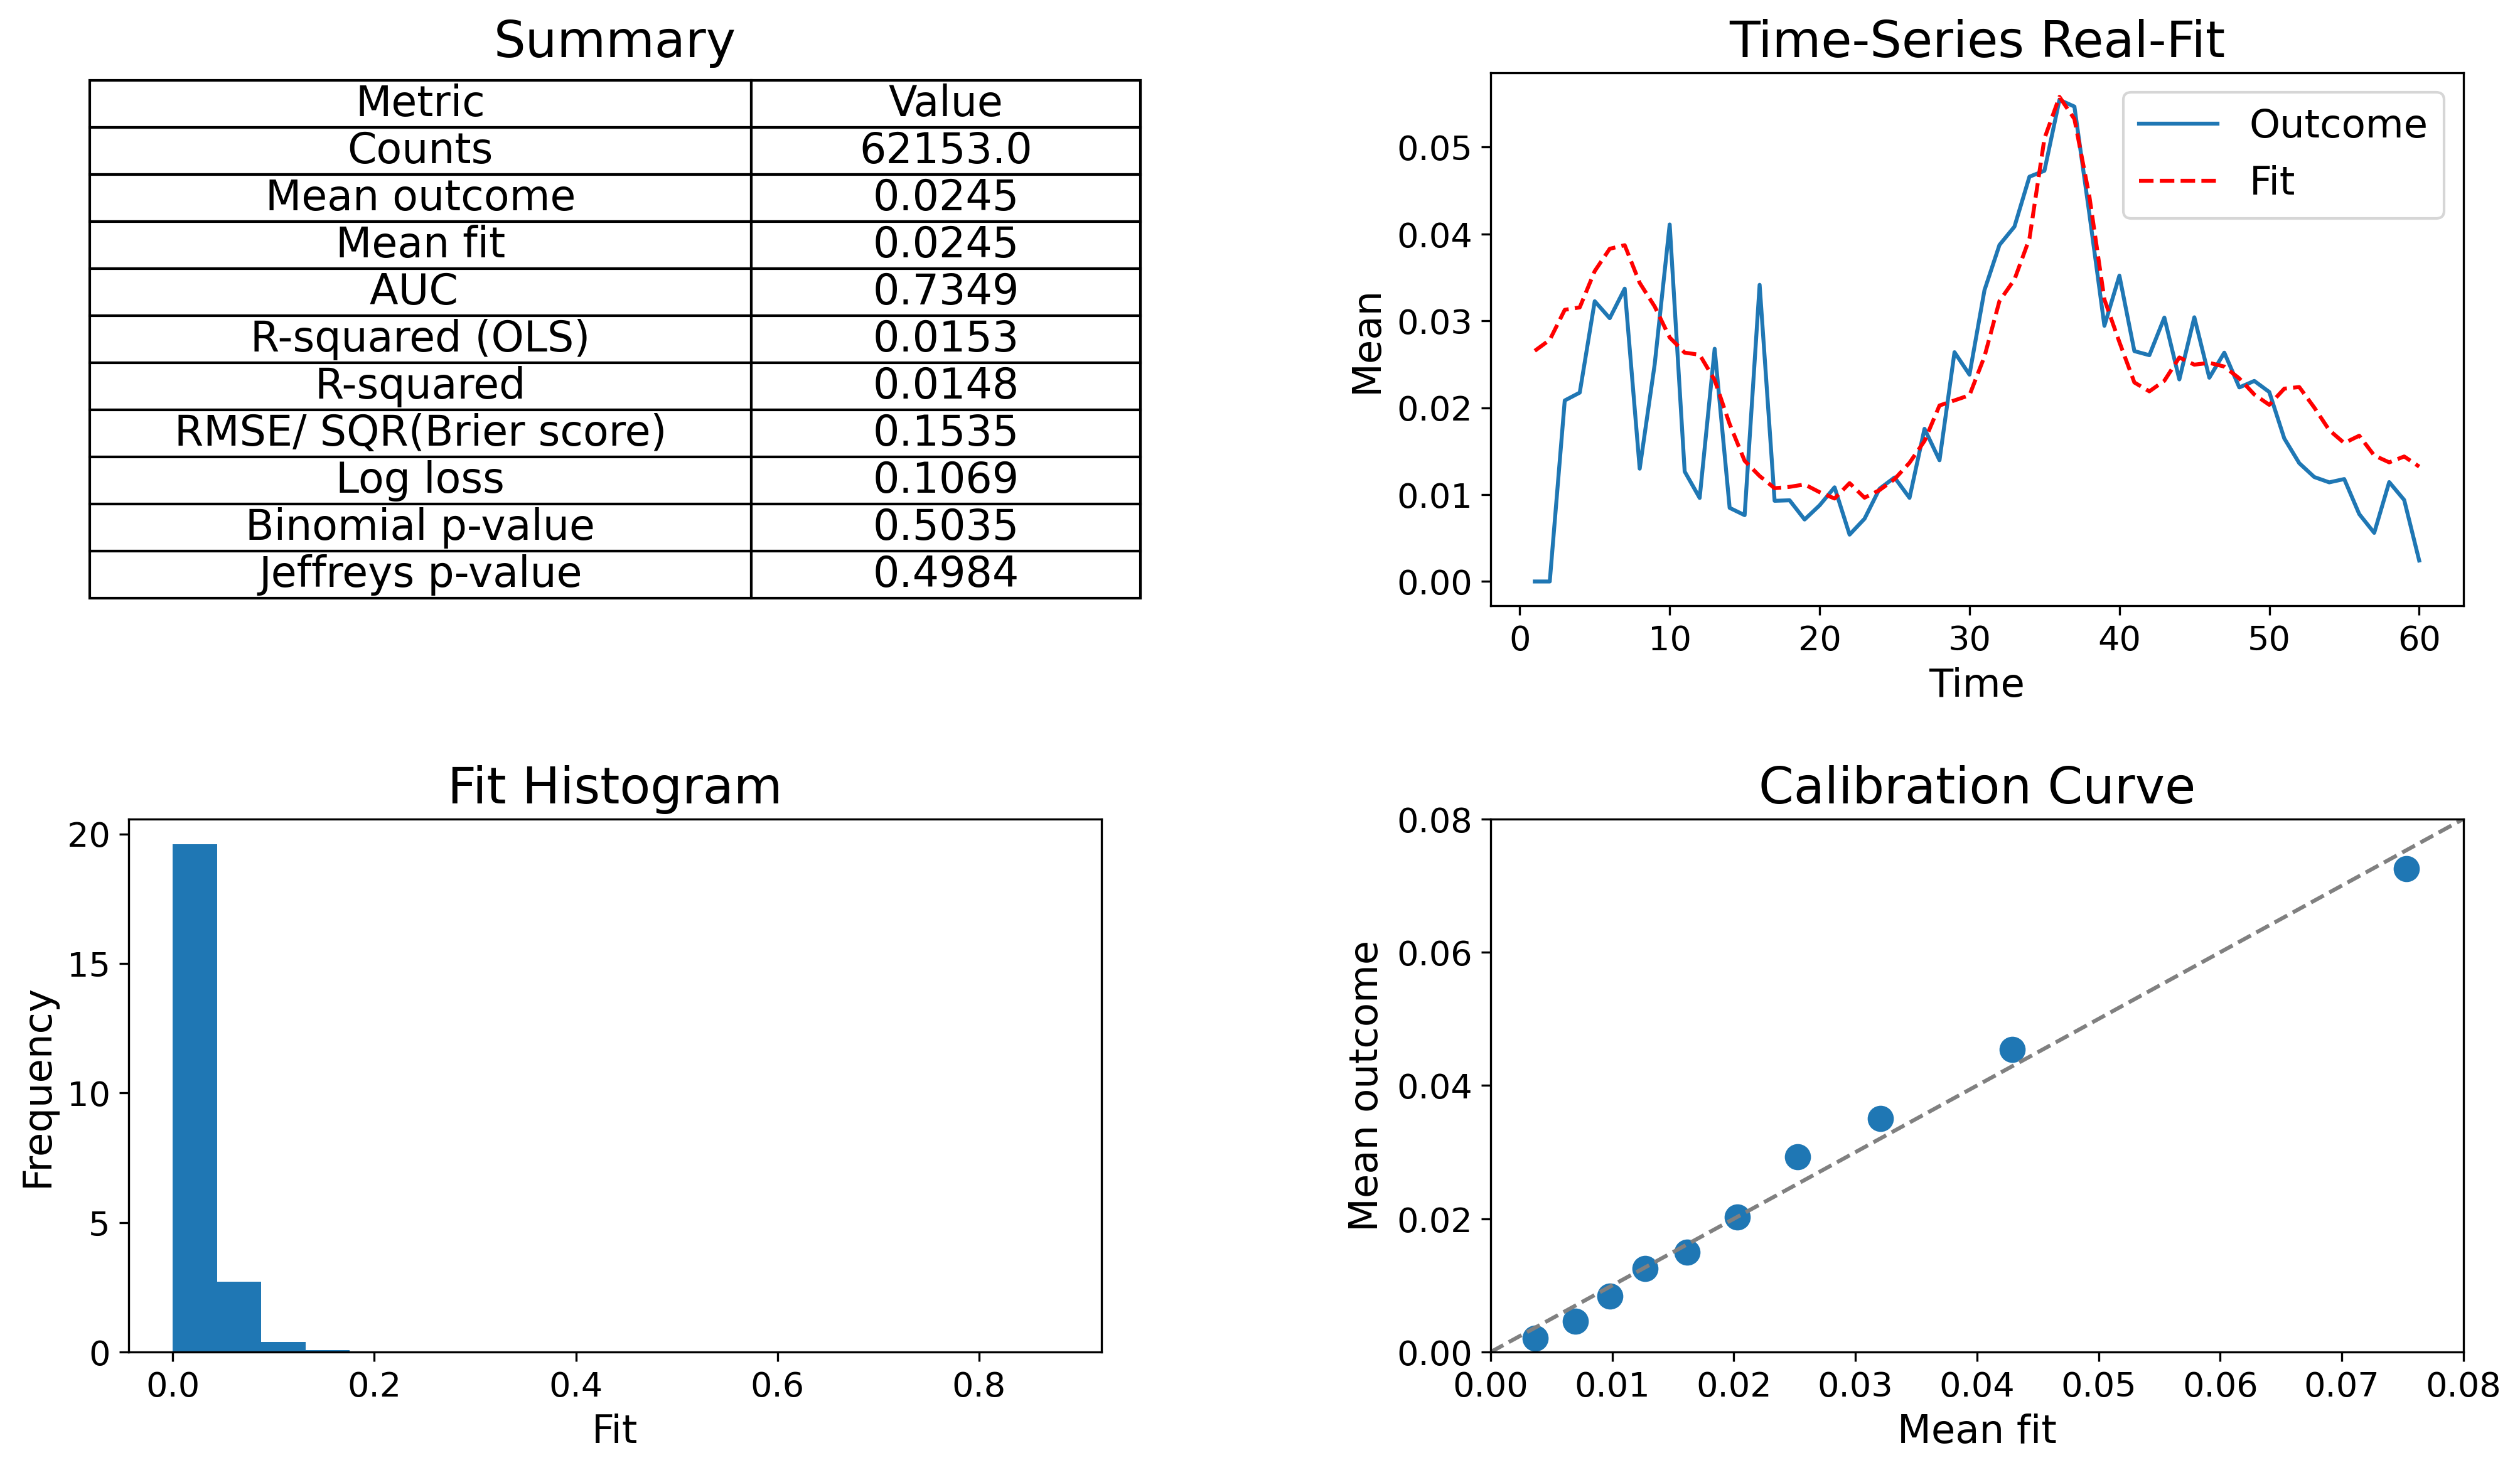

In [85]:
# Corremos la función
# Hacemos conclusiones
# Nótese las PDs elevadas en el periodo de crisis
validation(data2.PD_logit_model, data2.default_time, data2.time)

In [86]:
# El analisis de componentes principales se hará para ejemplificar la reduccion de dimensionalidad con PCA
# La variable de estado tiene los siguientes valores:
data.state_orig_time.unique()

array(['KY', 'CO', 'GA', 'TN', 'CA', 'AL', 'NJ', 'DC', 'NC', 'NY', 'FL',
       'WA', 'MD', 'AZ', 'SC', 'MN', 'TX', 'VA', 'OH', 'CT', 'ME', 'MI',
       'WI', 'PA', 'OK', 'NV', 'MA', 'LA', 'IL', 'NE', 'ND', 'MO', 'MT',
       'AR', 'OR', 'NM', 'UT', 'IA', 'SD', 'ID', 'HI', 'RI', 'IN', 'WV',
       'VT', 'MS', 'NH', 'DE', nan, 'KS', 'WY', 'PR', 'AK'], dtype=object)

In [87]:
# Una forma de incorporar esta variable es construir dummies con valores de 0 y 1 esto implicaría tener más de 40 variables
# Sin embargo podemos reducir dimensionalidad con el análisis de PCA
# Primero calcularemos las probabilidades de default de esta vaariable porque es lo que queremos ajustar.

defaultrates_states1 = data.groupby(['time','state_orig_time'])['default_time'].mean().unstack(level=1).add_prefix('defaultrate_').fillna(0).reset_index(drop=False)

In [90]:
# Ahora estandarizamos estos datos  y los ponemos en una matriz
scaler = StandardScaler()
defaultrates_states = scaler.fit_transform(defaultrates_states1)

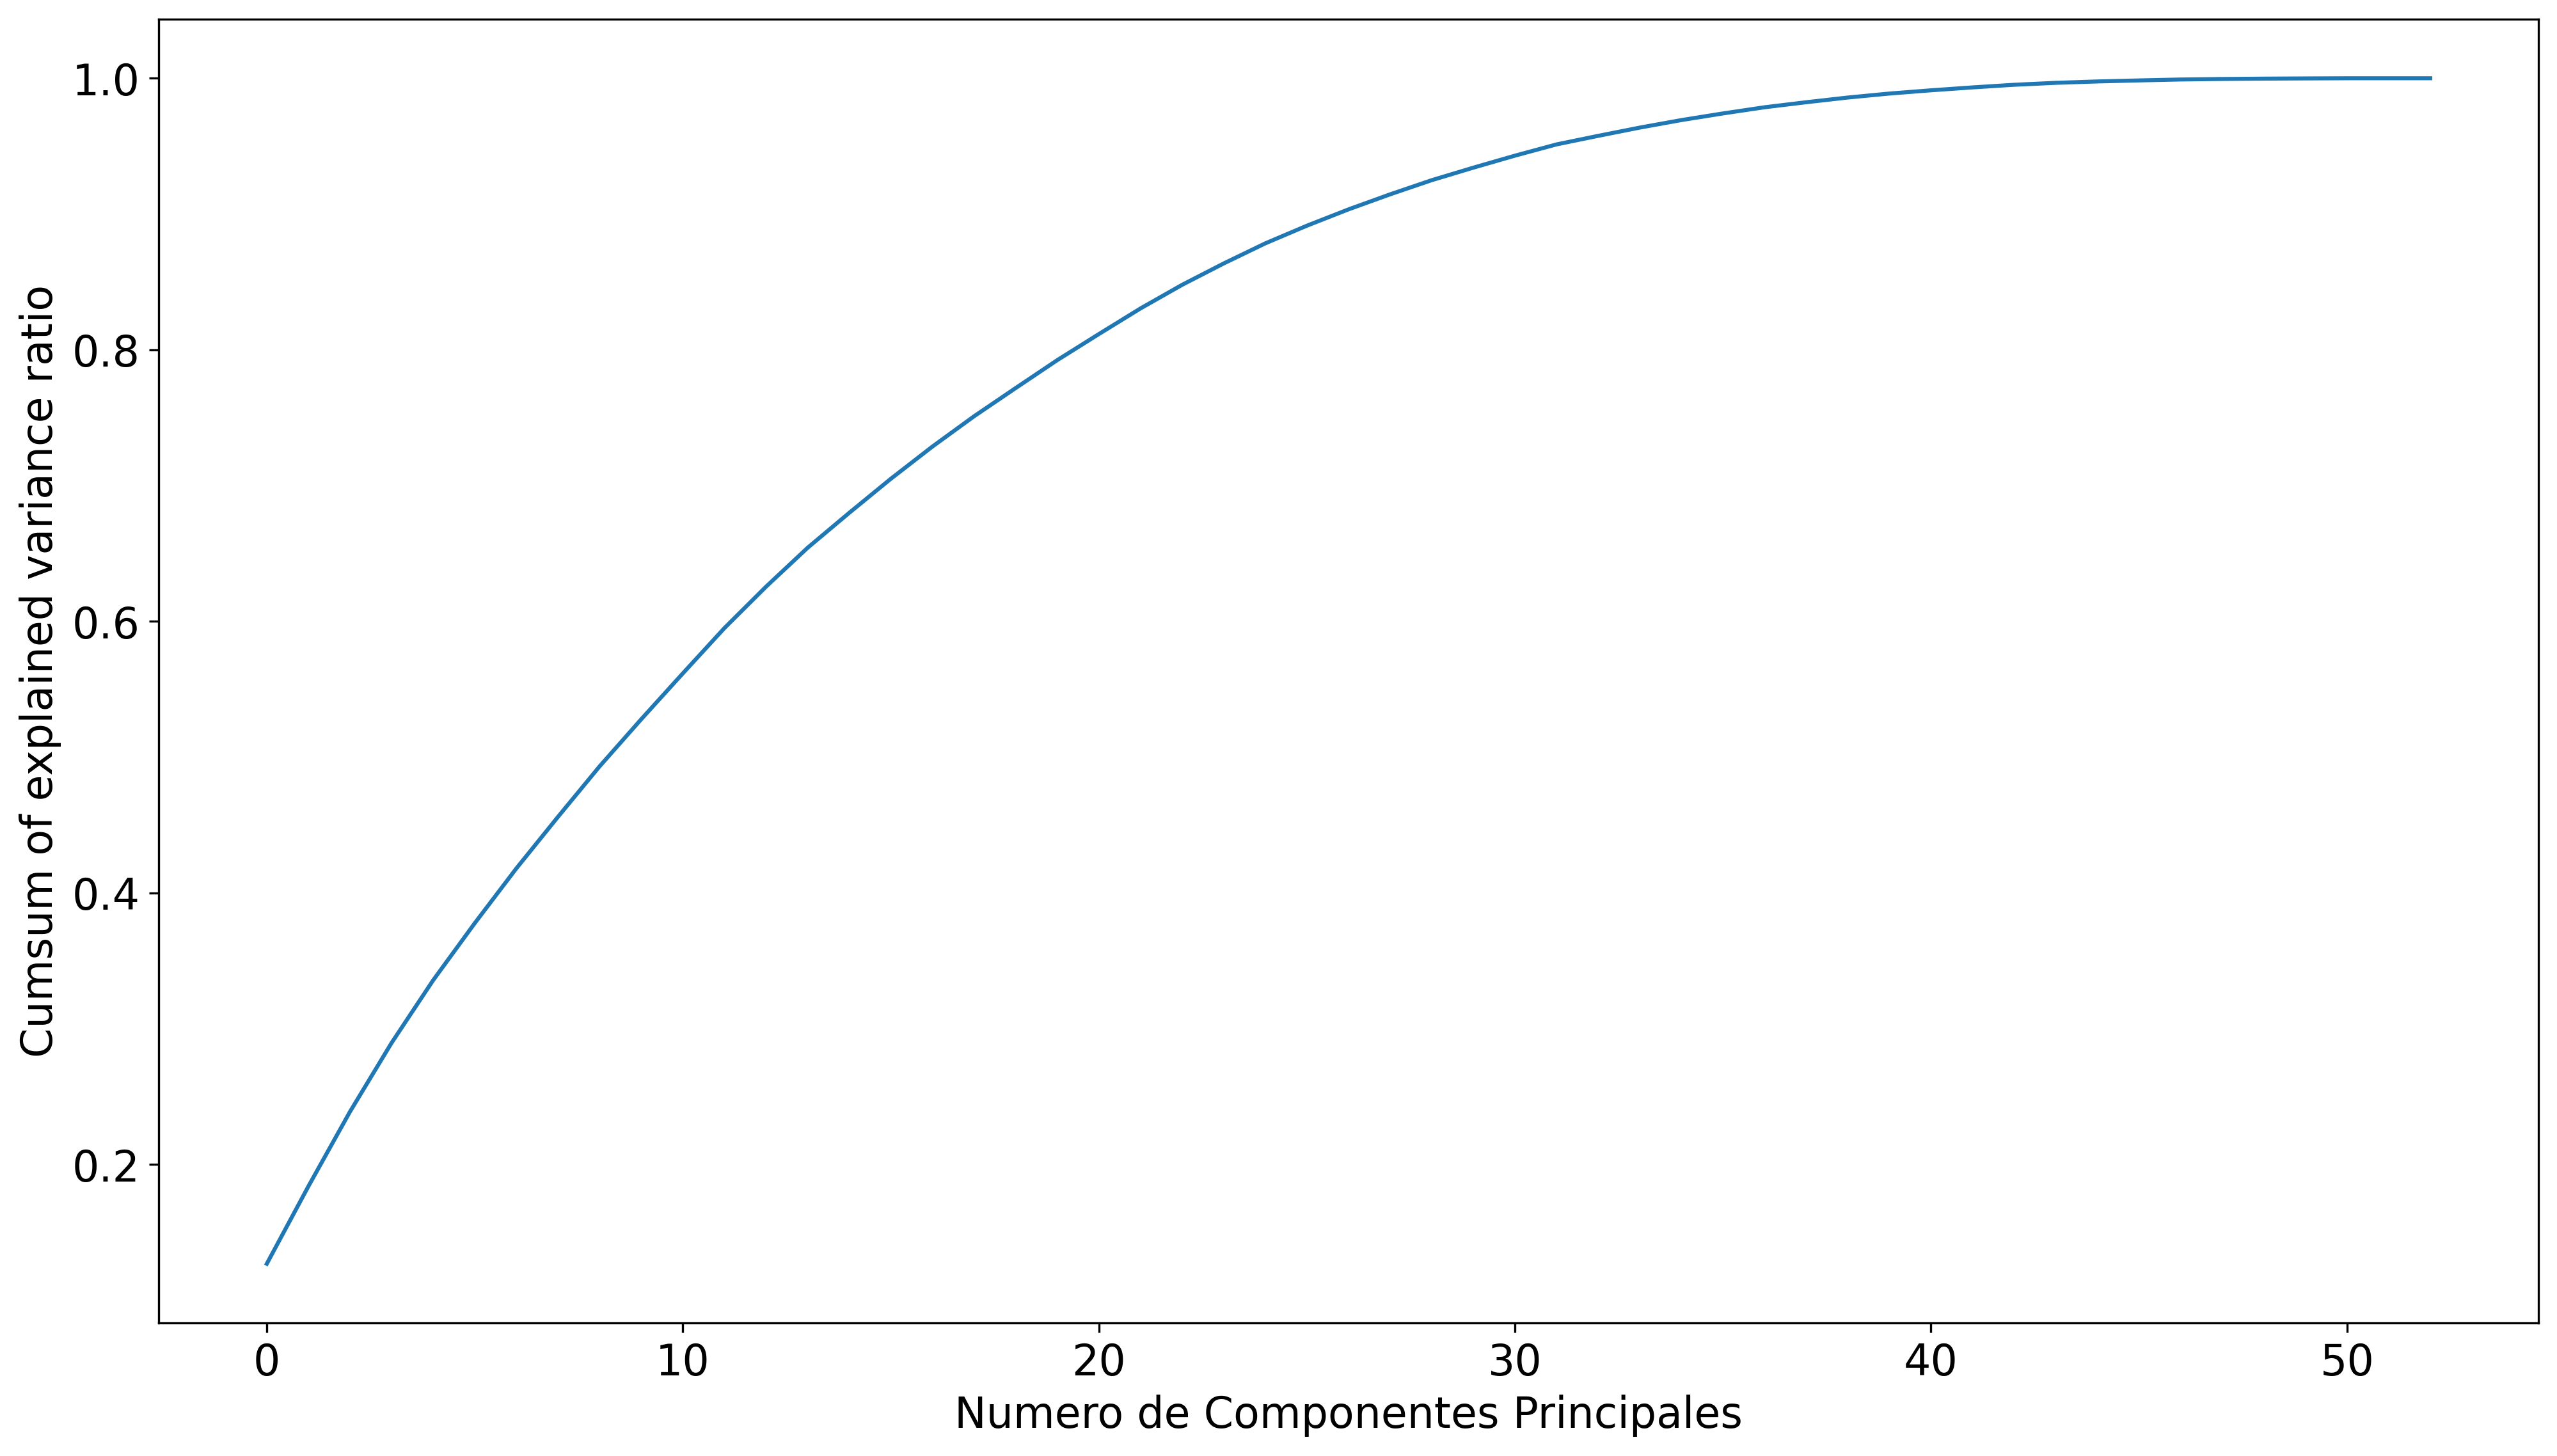

In [91]:
pca=PCA()
pca.fit(defaultrates_states)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Numero de Componentes Principales')
plt.ylabel('Cumsum of explained variance ratio')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

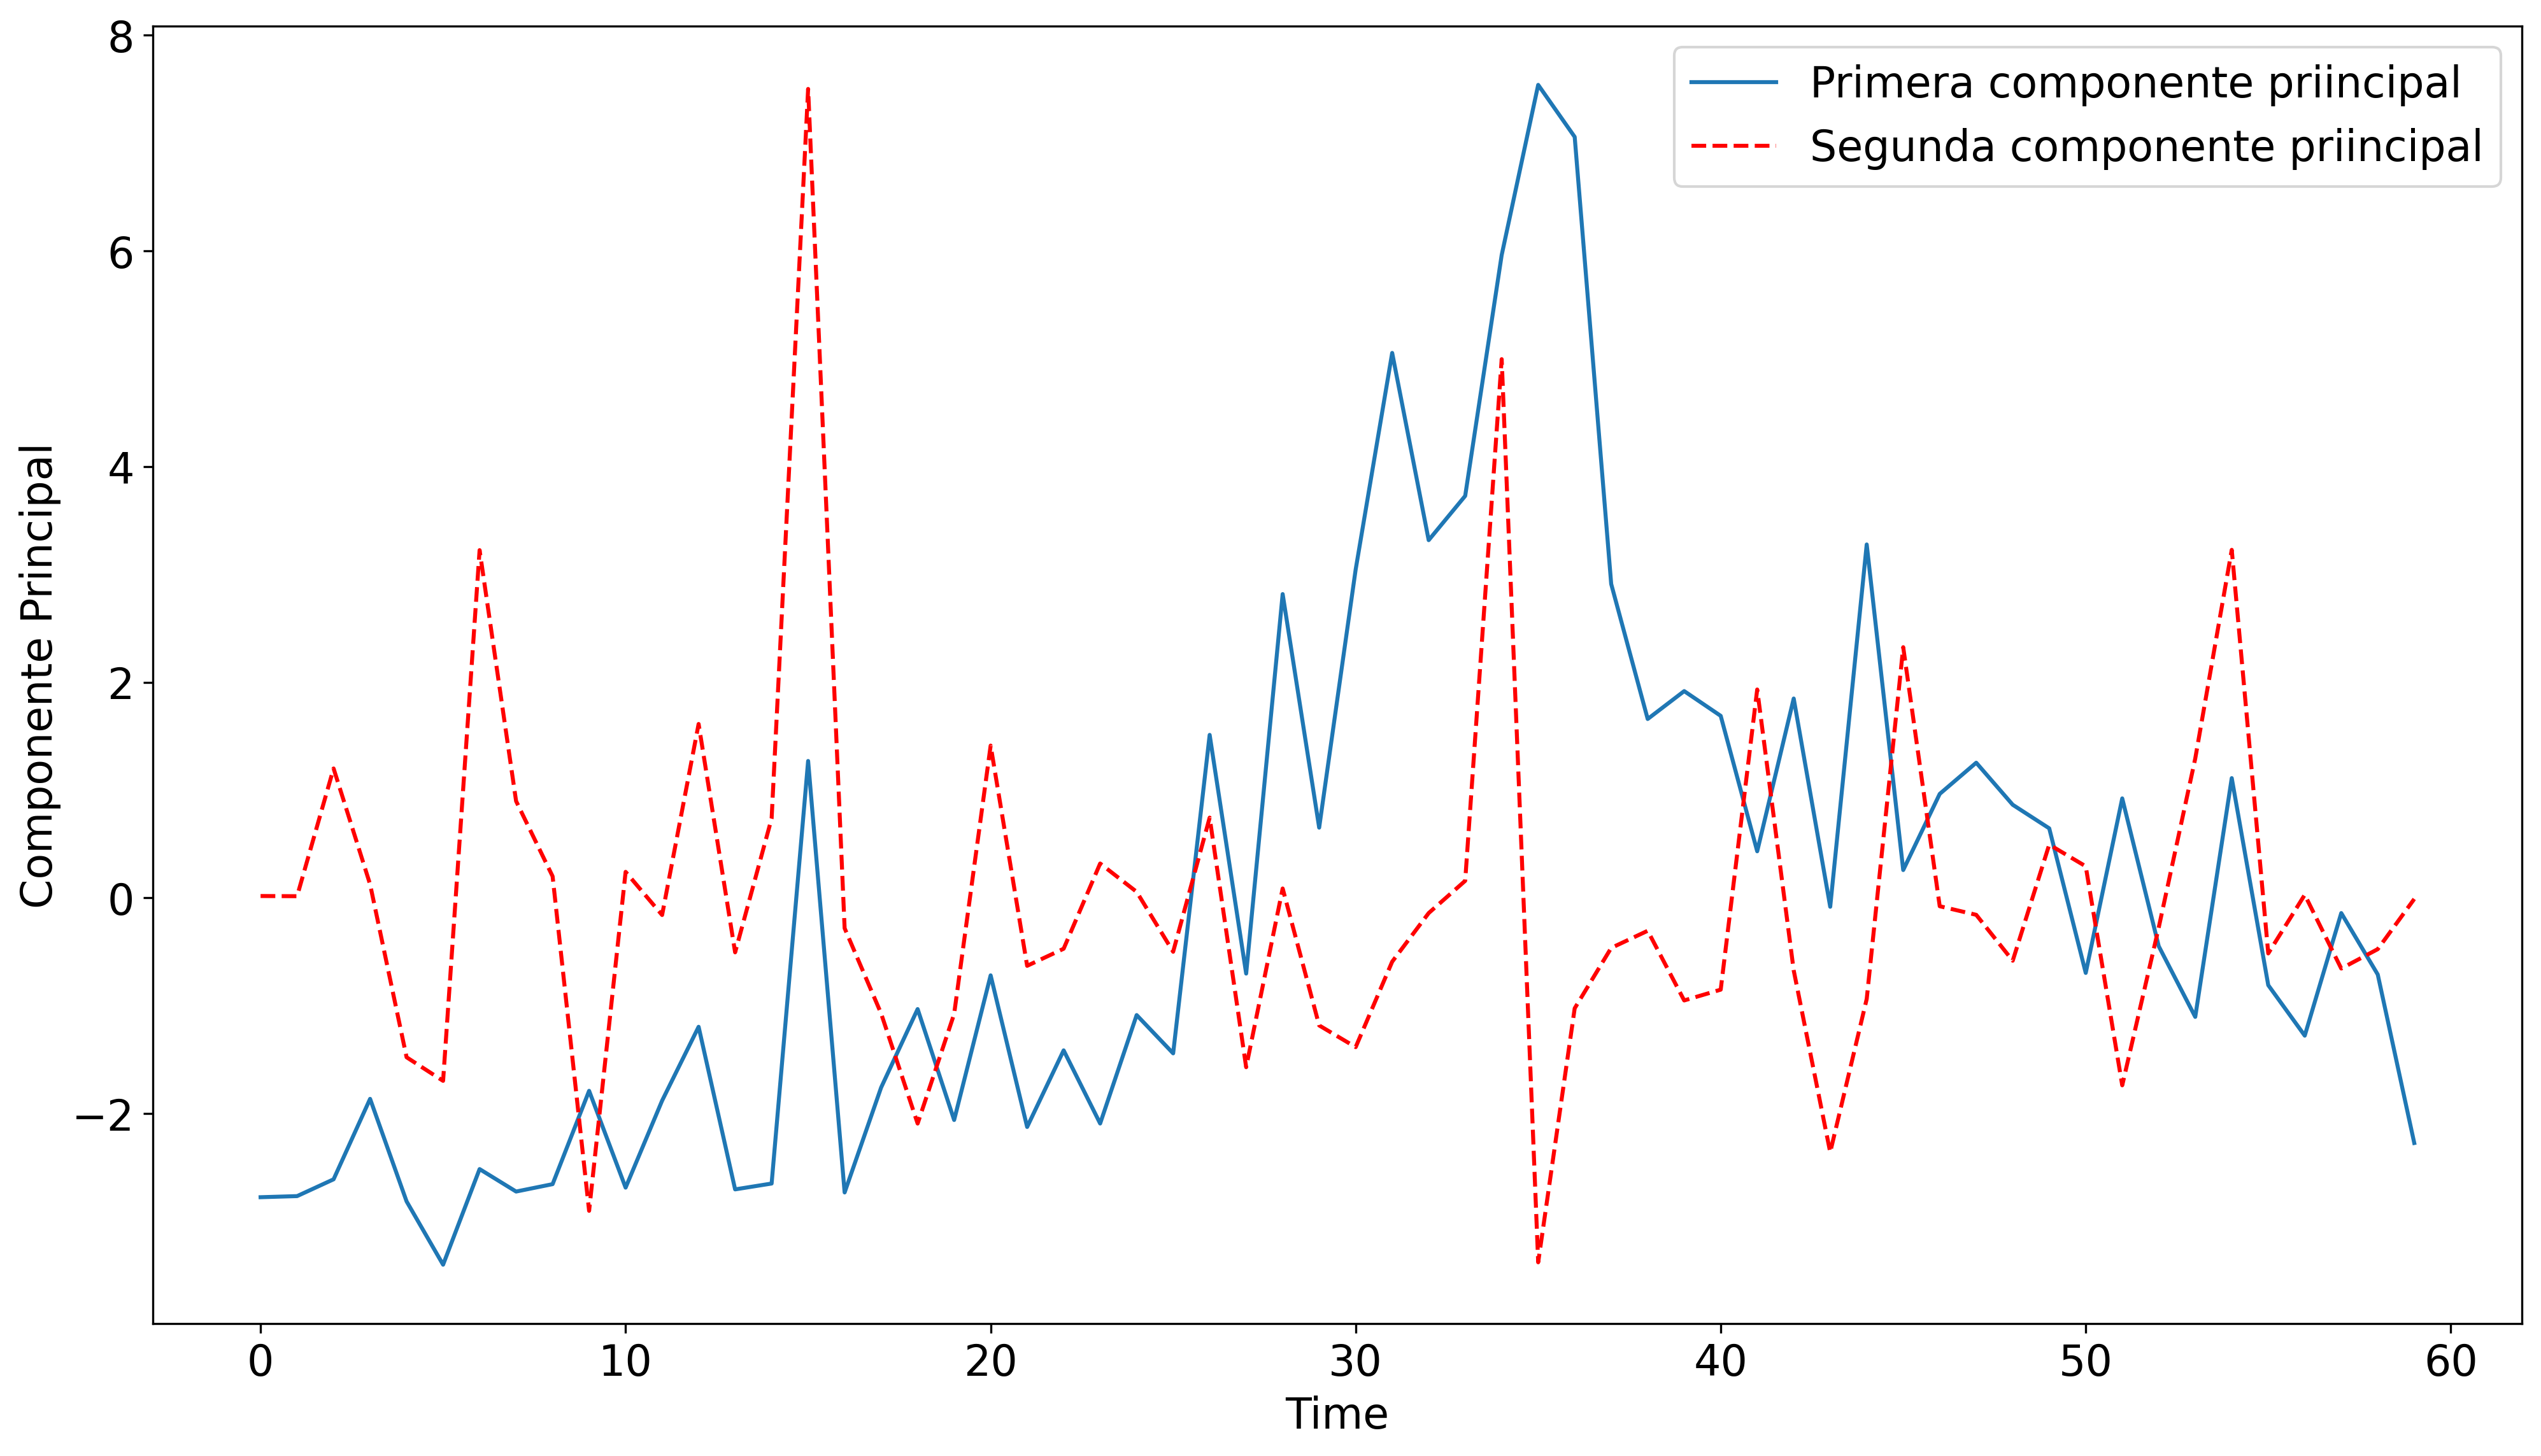

In [92]:
z = pca.transform(defaultrates_states)

plt.xlabel('Time')
plt.ylabel('Componente Principal')
plt.plot(defaultrates_states1.index, z[:,0], alpha =1, label = "Primera componente priincipal")
plt.plot(defaultrates_states1.index, z[:,1], alpha =1, color = 'red', linestyle = 'dashed', label = "Segunda componente priincipal")
plt.legend(loc='best')
plt.show

In [93]:
z = z[:,0:2]
Z = pd.DataFrame(data=z, columns=['PCA1', 'PCA2'])
Z_1 = Z.shift(1).add_suffix('_1')

In [94]:
defaultrates_states2 = pd.concat([defaultrates_states1['time'], Z_1], axis=1).dropna(subset=['PCA1_1']).copy() 
data_con_pca = pd.merge(data, defaultrates_states2, on='time')